<a href="https://colab.research.google.com/github/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_04_deterministic_nowcasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_04_deterministic_nowcasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nowcasting methods - part 1 deterministic forecasts

In this notebook we show how to construct, visualize, apply verification metrics to and export deterministic nowcasts using pysteps.


## Load the data from the previous exercises

First we install pysteps, load and preprocess the example data by running the [helper_nowcasting_methods](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/helper_nowcasting_methods.ipynb) notebook.

This helper notebook imports the FMI radar data, dBR transforms it and determines the motion field with the Lucas-Kanada optical flow method (see [the notebook of block 3](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_03_optical_flow_and_extrapolation.ipynb)). The precip data is split in a part for forecasting, called `precip_finite`, which is already dBR transformed and NaN values have been filled with a minimum value, and a part that will be used as observations (`precip_obs`) for model verification of the nowcasts. 

The metadata corresponding to `precip_finite` is `metadata_dbr` and the metadata of `precip_obs` is `metadata`. 

Finally the motion field variable is called `motion_field`. You can use these variables in these exercises.

In [1]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the data notebook to load the input dataset
%run helper_nowcasting_methods.ipynb

/content/mnt/MyDrive/Colab Notebooks
/content/mnt/MyDrive/Colab Notebooks
/content/mnt/MyDrive/Colab Notebooks
✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████

# Deterministic nowcasts

In the deterministic nowcasting part, we will use the loaded data to create a precipitation nowcast and calculate different verification metrics to assess the skill of the nowcast compared to observations.

The first step is to make a nowcast using the **extrapolation** nowcasting method that simply extrapolates the last observed precipitation field along the motion field. You can follow the example in the [PySTEPS example gallery](https://pysteps.readthedocs.io/en/stable/auto_examples/plot_extrapolation_nowcast.html#sphx-glr-auto-examples-plot-extrapolation-nowcast-py). Calculate the nowcasts for 12 leadtimes, i.e. for 1 hour, and visualize some nowcasts with the observations.

The semi-Lagrangian extrapolation method has some keyword arguments that can improve the quality of the nowcast depending on the data. For a full list of the arguments, see the [pySTEPS documentation](https://pysteps.readthedocs.io/en/latest/generated/pysteps.extrapolation.semilagrangian.extrapolate.html).

After creating the nowcast, calculate and visualize the probability of detection (POD), false alarm ratio (FAR), equitable threat score (ETS), and the mean error (ME) for the nowcast as a function of leadtime.

Finally, export the nowcasts into NetCDF format using the `pysteps.io.exporters` module.

If time allows, you can make nowcasts using other methods, for example S-PROG or LINDA (the deterministic version). You can compare the nowcasts visually by plotting them and statistically by calculating the verification metrics for all the nowcasting methods and plotting them in the same figure.

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from pysteps import nowcasts
from pysteps.visualization import plot_precip_field
%matplotlib inline

# Set nowcast parameters
n_leadtimes = 12

# The extrapolation method has some keyword arguments that can be used to control the nowcasting
extrap_kwargs = {
  "allow_nonfinite_values": False,
  "interp_order": 1,
}

# The extrapolation nowcast
nowcast_method = nowcasts.get_method("extrapolation")
precip_extrap = nowcast_method(
    precip_finite[-1:, :, :].squeeze(),
    motion_field,
    timesteps=n_leadtimes,
    extrap_method="semilagrangian",
    extrap_kwargs=extrap_kwargs,
)

# Back-transform the results from dBR to rain rates
precip_extrap = transformation.dB_transform(
    precip_extrap, 
    threshold=metadata_dbr["threshold"], 
    inverse=True
    )[0]

# Calculate the S-PROG nowcast for comparison
# S-PROG requires as many input fields as 1 + degree of the AR process
# and some other arguments
nowcast_method = nowcasts.get_method("sprog")
precip_sprog = nowcast_method(
    precip_finite[-3:, :, :],
    motion_field,
    timesteps=n_leadtimes,
    n_cascade_levels=6,
    R_thr=metadata_dbr["threshold"],
)

# Back-transform the results from dBR to rain rates
precip_sprog = transformation.dB_transform(
    precip_sprog, 
    threshold=metadata_dbr["threshold"], 
    inverse=True
    )[0]


/usr/local/lib/python3.7/site-packages/pysteps/decorators.py:311: FutureWarning: Argument 'R_thr' has been renamed to 'precip_thr'. This will raise a TypeError in pysteps 1.8.0.
  FutureWarning,


Computing S-PROG nowcast
------------------------

Inputs
------
input dimensions: 613x380

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
conditional statistics: no
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
| Level |     Lag-1     |     Lag-2     |
-----------------------------------------
| 1     | 0.999454      | 0.998889      |
-----------------------------------------
| 2     | 0.996606      | 0.988416      |
-----------------------------------------
| 3     | 0.986581      | 0.952373      |
---------------------

### Visualize the results

Visualize the observations and the nowcasts for a few lead times. An example on how to do this is provided in [the STEPS nowcast gallery example](https://pysteps.readthedocs.io/en/latest/auto_examples/plot_steps_nowcast.html#stochastic-nowcast-with-steps). You can plot the observations on one row and the corresponding nowcasts below them.

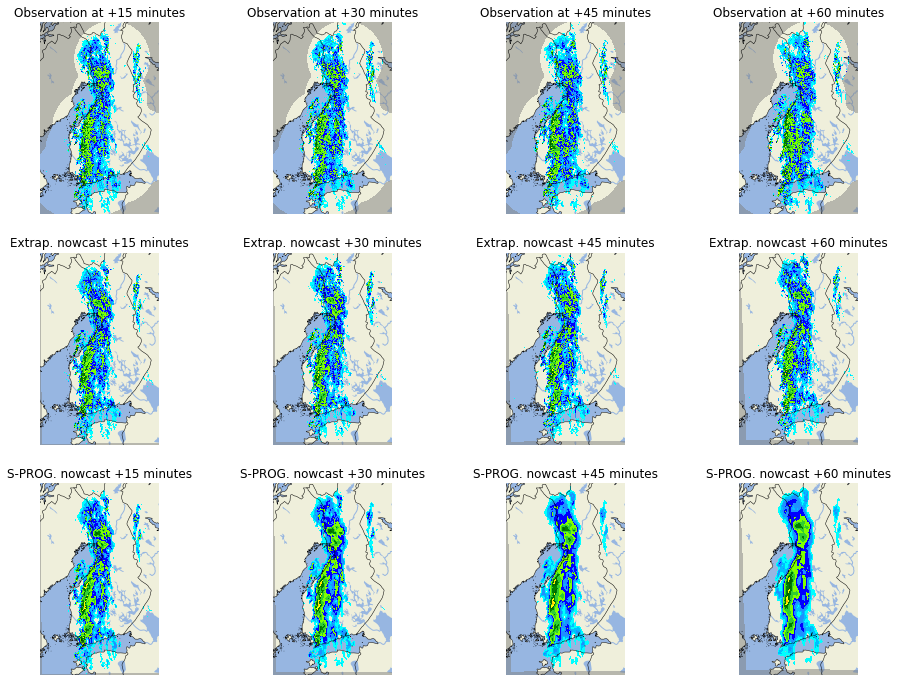

In [3]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(16, 12))
# First plot the observations
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(3, 4, 1 + i)
    plot_precip_field(
        precip_obs[j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"Observation at +{(j + 1) * 5} minutes")

# We'll plot the nowcast for four lead times
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(3, 4, 5 + i)
    plot_precip_field(
        precip_extrap[j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"Extrap. nowcast +{(j + 1) * 5} minutes")

for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(3, 4, 9 + i)
    plot_precip_field(
        precip_sprog[j], 
        geodata=metadata, 
        colorscale="STEPS-BE", 
        colorbar=False
        )
    plt.title(f"S-PROG. nowcast +{(j + 1) * 5} minutes")


### Deterministic nowcast verification

Deterministic nowcasts can be verified with pySTEPS using different kind of metrics: continuous, categorical, spatial and SAL scores.

* `pysteps.verification.detcatscores` contains methods to calculate categorical metrics, i.e. metrics calculated for some rain rate thresholds, for example probability of detection (POD) and false alarm ratio (FAR).
* `pysteps.verification.detcontscores` contains methods to calculate continuous verification metrics, for example mean absolute error (MAE).
* `pysteps.verification.spatialscores` contains methods for calculating the Fractions Skill Score (FSS) and the Binary mean squared error (BMSE).
* `pysteps.verification.salscores` contains methods for calculating the Spatial-Amplitude-Location (SAL) score defined by Wernli et al. (2008)

We will calculate probability of detection (POD), false alarm ratio (FAR), equitable threat score (ETS), and the mean error (ME) for the nowcast as a function of leadtime, and visualize them.

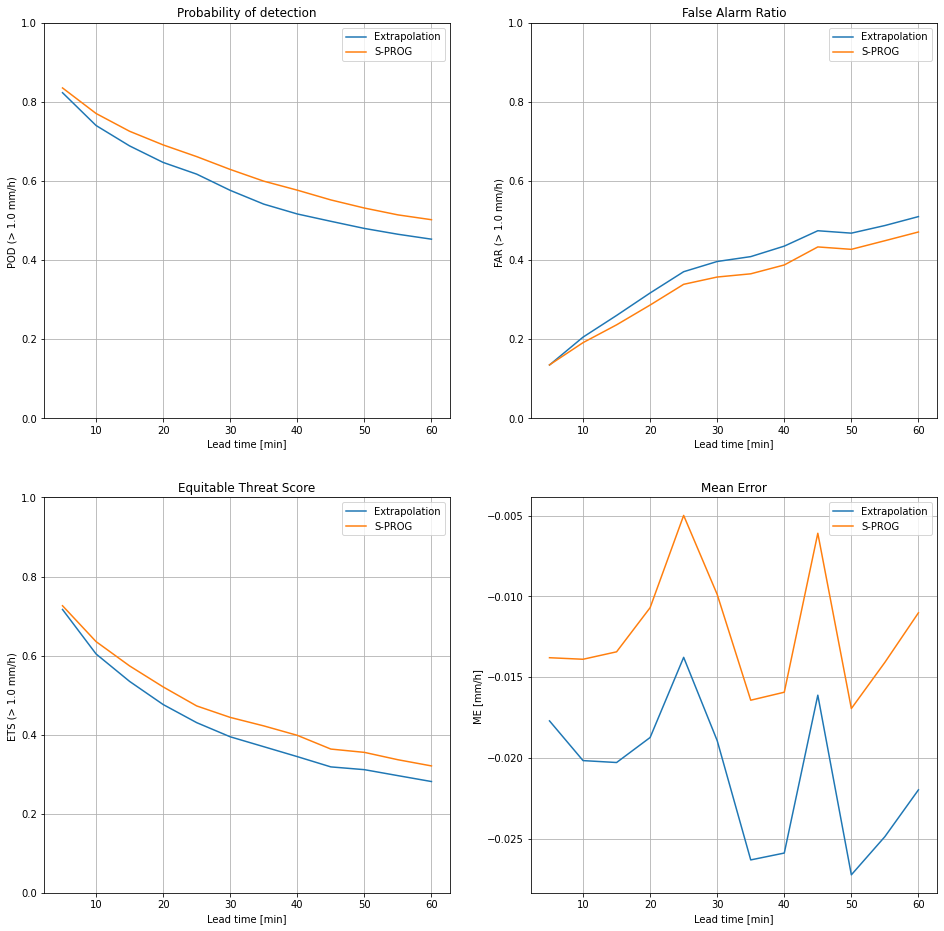

In [4]:
from collections import defaultdict
from pysteps import verification


scales = [2, 4, 8, 16, 32, 64, 128, 256, 512]
thr = 1.0
cat_scores = ["POD", "FAR", "ETS"]
cont_scores = ["ME", ]
score = []
score_baseline = []
score_sprog = []
score_steps = []

# Calculate scores for each leadtime
cat_extrap_scores = defaultdict(list)
cat_sprog_scores = defaultdict(list)
cont_extrap_scores = defaultdict(list)
cont_sprog_scores = defaultdict(list)

for i in range(n_leadtimes):
    extrap_score = verification.detcatscores.det_cat_fct(precip_extrap[i], precip_obs[i], thr=thr, scores=cat_scores)
    sprog_score = verification.detcatscores.det_cat_fct(precip_sprog[i], precip_obs[i], thr=thr, scores=cat_scores)

    for name in cat_scores:
        cat_extrap_scores[name].append(extrap_score[name])
        cat_sprog_scores[name].append(sprog_score[name])

    extrap_score = verification.detcontscores.det_cont_fct(precip_extrap[i], precip_obs[i], scores=cont_scores)
    sprog_score = verification.detcontscores.det_cont_fct(precip_sprog[i], precip_obs[i], scores=cont_scores)

    for name in cont_scores:
        cont_extrap_scores[name].append(extrap_score[name])
        cont_sprog_scores[name].append(sprog_score[name])

# Plot scores

plt.figure(figsize=(16, 16))
x = np.arange(1, n_leadtimes + 1) * metadata["accutime"]

plt.subplot(2, 2, 1)
plt.plot(x, cat_extrap_scores["POD"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["POD"], label="S-PROG")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"POD (> {thr} mm/h) ")
plt.title("Probability of detection")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(x, cat_extrap_scores["FAR"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["FAR"], label="S-PROG")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"FAR (> {thr} mm/h) ")
plt.title("False Alarm Ratio")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(x, cat_extrap_scores["ETS"], label="Extrapolation")
plt.plot(x, cat_sprog_scores["ETS"], label="S-PROG")
plt.ylim([0, 1])
plt.xlabel("Lead time [min]")
plt.ylabel(f"ETS (> {thr} mm/h) ")
plt.title("Equitable Threat Score")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(x, cont_extrap_scores["ME"], label="Extrapolation")
plt.plot(x, cont_sprog_scores["ME"], label="S-PROG")
plt.xlabel("Lead time [min]")
plt.ylabel(f"ME [mm/h] ")
plt.title("Mean Error")
plt.legend()
plt.grid()



## Exporting nowcasts

Finally, let's export the nowcasts to NetCDF format using the `pysteps.io.exporters`. For exporting, the exporter needs to first be initialized before it can be used to save the nowcasts. Remember to close the exporter after saving the nowcast.

In [5]:
from pysteps import io

# Initialize the exporter
exporter = io.exporters.initialize_forecast_exporter_netcdf(
    "/content/mnt/MyDrive/Colab Notebooks", 
    "extrapolation_nowcast", 
    metadata_dbr["timestamps"][0], 
    metadata["accutime"], 
    n_leadtimes, 
    precip_obs.shape[-2:], 
    metadata, 
  )

# Save nowcast
io.exporters.export_forecast_dataset(precip_extrap, exporter)

# Remember to close the exporter
io.exporters.close_forecast_files(exporter)